# Hate Speech Detection on English tweets

Author: Bigarella Chiara

## 1 - Introduction

Natural Language Processing tasks have been widely studied in the context of big corpora, but, when applied to social media content, they have been proven to be harder. This is mainly due to the following reasons:

- Social media have a high-paced, conversational and idiosyncratic nature;
- There might be restrictions on the number of characters allowed (this is the case on Twitter);
- Short texts cointain a limited amount of contextual cues;
- The lack of a unified evaluation framework makes it hard to compare different models.

In this notebook we will use **BERTweet**, a large-scale language model pretrained on English tweets, and we will evaluate its performances on the **Hate Speech Detection** task, which consists in understanding whether a tweet is hateful or not toward certain target communities.

Below, you can see an example of the aforementioned task:


``` python
# Hate Speech detection
tweet = "THIS WOMEN CAN DO ONLY ONE THINK, BACK INTO HER RAT🐀 HOLE NEVER TO COME OUT AGAIN🐀IF SHE SHOW UP ON SURFACE AM CALL…"
tokenized_tweet = tokenizer(tweet)
predictions = model_hate.predict(tokenized_tweet)
preds = np.argmax(predictions.predictions, axis=-1)
preds

> 1 # Hate
```

## 2 - Model

[BERTweet](https://huggingface.co/vinai/bertweet-base) is the first large-scale language model based on the $BERT_{base}$ architecture, that has been pretrained using a corpus of 850M English Tweets. The training of the model is based on the $RoBERTa$ pre-training procedure, which leads to more robust performances compared to the $BERT$ pretraining approach ([Nguyen et al. ,2020](https://aclanthology.org/2020.emnlp-demos.2/)).

BERT, which stands for **Bidirectional Encoder Representations from Transformers**, is a language representation model based on a multi-layer bidirectional Transformer encoder that jointly conditions on both left and right context in all layers. It has been pre-trained using a Masked Language Model (MLM) objective together with a Next Sentence Prediction task ([Devlin et al., 2019](https://arxiv.org/abs/1810.04805)).

The pre-trained BERT model can be easily finetuned by adding a single output layer and using the labeled data from the downstream task to update all the training parameters.


## 3 - Methodology

In order to perform the Hate Speech Detection task,
we will finetune the $BERTweet_{base}$ model on the **TweetEval hate** dataset, belonging to the [TweetEval](https://huggingface.co/datasets/tweet_eval) framework.
This dataset is based on the SemEval2019 Hateval challenge and each tweet is associated with a label stating whether the tweet is hatefull or not against immigrants and women.

A detailed overview of the dataset can be found in the Exploratory Data Analysis part of the Experiments section.




We will perform the finetuning using two kinds of data:
- The original tweets, as they are provided in the dataset;
- Tweets that have been preprocessed using the `preprocess_tweet` function of the [pysentimiento](https://github.com/pysentimiento/pysentimiento) library.

The `preprocess_tweet` function performs the following actions on the original tweets:

1. It replaces all the emojis with the corresponding text, delimited by the word `emoji`.
2. It removes all the hashtag symbols (`#`).
3. Hashtags where the first letter of each word is capitalized, are split into the corresponding words and the first letters get changed to lowercase.
4. It replaces urls with the world `HTTPURL`.
5. It anonymizes all the users' mentions by replacing the usernames with `@USER`.

Here you can find an example of preprocessing of a tweet:
``` python
tweet = "Now that @user has snapchat back it's a constant battle to see who can get the ugliest snap of one another 😂🙃 #SnapSurvival"
preprocessed_tweet = preprocess_tweet(tweet, lang="en")
preprocessed_tweet

> "Now that @USER has snapchat back it's a constant battle to see who can get the ugliest snap of one another  emoji face with tears of joy emoji  emoji upside-down face emoji  snap survival"
```


During the finetuning process, a validation set is used to select the batch size and the number of epochs. To do so, we only consider the values suggested by the [Devlin et al., 2019](https://arxiv.org/abs/1810.04805) for finetuning BERT:
- Batch size: `16, 32`
- Number of epochs: `2, 3, 4`

Due to limited hardware resources, we won't select the learning rate optimal value, but we will rather use the default value of the Hugging Face [TrainingArguments](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments) class, i.e. `5e-5`. This value is among the suggested learning rates for the finetuning of BERT (`5e-5, 3e-5, 2e-5`).

Finally, we will evaluate the resulting models by computing the following metrics on the corresponding test sets:
- Accuracy
- Macro-averaged precision: $P = \frac{TP}{TP + FP}$
- Macro-averaged recall: $R = \frac{TP}{TP + FN}$
- Macro-averaged $F_{1}$ score: $F_{1} = 2 \frac{P * R}{P + R}$

In particular, macro-averaged $F_{1}$  score is the metric suggested by the TweetEval framework to evaluate Hate Speech Detection on tweets.

However, note that the macro average is an unweighted mean and therefore it does not take label imbalance into account.

## 4 - Experiments

This section contains the entire code needed to carry out the task, and its related output.

### 4.1 Setup

In [ ]:
! pip uninstall folium --yes
! pip install datasets

! pip install pysentimiento

! pip install transformers

! pip install colorama

In [ ]:
from collections import defaultdict
import colorama
from colorama import Fore
from datasets import load_dataset, load_metric
import matplotlib.pyplot as plt
import numpy as np
from pysentimiento.preprocessing import preprocess_tweet
import seaborn as sns

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, \
    AdamW, get_linear_schedule_with_warmup, TrainingArguments, Trainer

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
COLORS_PALETTE = ["#d952a1", "#3C9BFA",  "#04C896",  "#FCB405",  "#7C5CFF", "#FC8204"]
sns.set_palette(sns.color_palette(COLORS_PALETTE))

RANDOM_SEED = 5
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [ ]:
BERTWEET_BASE = 'vinai/bertweet-base'

### 4.2 - Exploratory Data Analysis

In this section we will download the data from the TweetEval dataset related to Hate Speech Detection, and we will perform some explorary data analysis.

The table below shows a summary of the dataset. Note that the dataset is already split into train, validation and test set.

Dataset   | Lables | Train | Validation | Test
----------|--------| ------| -----------| ----
hate      | ['non-hate', 'hate'] | 9000  | 1000       | 2970


As we can see, the *hate* dataset is pretty small. This might lead to low performances in the Hate Speech Detection task.


In [ ]:
# BERTweet tokenizer
tokenizer = AutoTokenizer.from_pretrained(BERTWEET_BASE)

In [ ]:
# Helper functions

def dataset_overview(name, train, val, test):
  """ Print the dataset's information. """

  print(f"** {name} **\n")
  print("Features:", train.features)
  print("Training examples:", train.num_rows)
  print("Validation examples:", val.num_rows)
  print("Test examples:", test.num_rows)


def show_data_examples(data, first, last, color=Fore.BLUE):
  """ Print some dataset examples. """

  print('EXAMPLES:\n')
  for idx in range(first, last):
    tweet = data['text'][idx]
    label = data['label'][idx]
    print(f"{Fore.BLACK} {idx + 1}. {tweet} -> {color} {data.features['label'].int2str(label)}")


def labels_piechart(train, val, test):
  """ Generate three pie charts, one for the train, one for the validation and 
  one for the test sets. Each pie chart shows the labels frequencies as 
  percentages. """

  classes, counts = np.unique(train['label'], return_counts=True)
  val_classes, val_counts = np.unique(val['label'], return_counts=True)
  test_classes, test_counts = np.unique(test['label'], return_counts=True)

  # Pie chart, where the slices will be ordered and plotted counter-clockwise:
  fig1, ax = plt.subplots(1, 3, figsize=(20, 8))

  ax[0].pie(counts, labels=classes, autopct='%1.1f%%', startangle=90, textprops={'size':15})
  ax[0].axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
  ax[0].set_title("Training set", size=15)

  ax[1].pie(val_counts, labels=val_classes, autopct='%1.1f%%', startangle=90, textprops={'size':15})
  ax[1].axis('equal')
  ax[1].set_title("Validation set", size=15)

  ax[2].pie(test_counts, labels=test_classes, autopct='%1.1f%%', startangle=90, textprops={'size':15})
  ax[2].axis('equal')
  ax[2].set_title("Test set", size=15)

  plt.show()


def count_sequence_length(train, val, test):
  """ Count the length of the token's sequences in the entire datasets (train,
  validation and test sets). """

  token_lens = []

  for txt in train['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

  for txt in val['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

  for txt in test['text']:
    tokens = tokenizer.encode(txt, max_length=512, truncation=True)
    token_lens.append(len(tokens))

  return token_lens


def plot_sequence_length(token_lens):
  """ Plot an histogram of the token sequence lengths. """

  fig1, ax = plt.subplots(1, 1, figsize=(20, 8))

  sns.histplot(token_lens, kde=True)

  plt.xlim([0, 150]);
  plt.xlabel('Tokens');


def preprocessing_function(example):
  """ Preprocess a tweet using the 'preprocess_tweet' function. """
  
  example_cp = example.copy()
  preprocessed_tweet = preprocess_tweet(example_cp['text'], lang="en")
  example_cp['text'] = preprocessed_tweet
  return example_cp

In [ ]:
# Load dataset
train_hate = load_dataset('tweet_eval', 'hate',  split='train')
val_hate = load_dataset('tweet_eval', 'hate',  split='validation')
test_hate = load_dataset('tweet_eval', 'hate',  split='test')

In [ ]:
# Dataset overview
dataset_overview('Hate Speech dataset', train_hate, val_hate, test_hate)

** Hate Speech dataset **

Features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=2, names=['non-hate', 'hate'], id=None)}
Training examples: 9000
Validation examples: 1000
Test examples: 2970


**Class frequency**

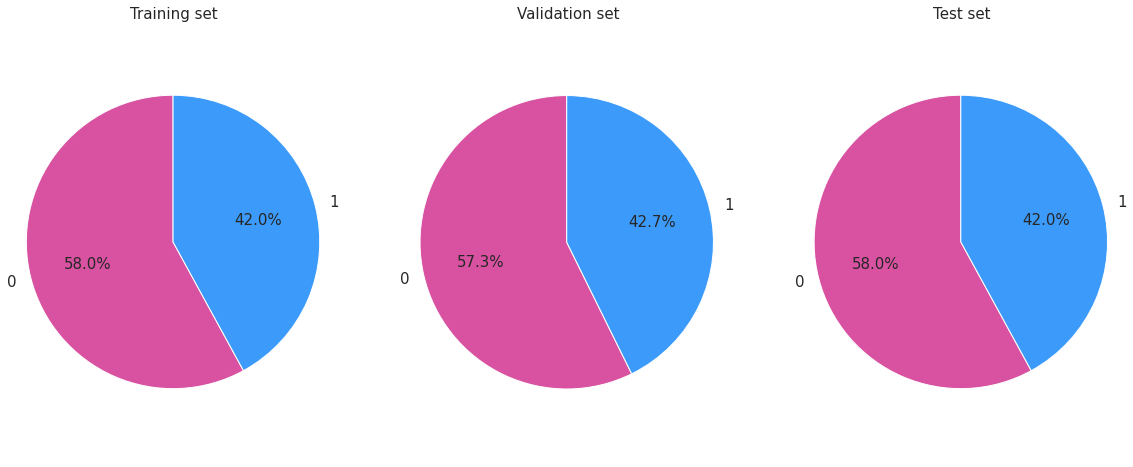

In [ ]:
labels_piechart(train_hate, val_hate, test_hate)

# 0 -> non-hate
# 1 -> hate

As we can see from the pie charts above, the dataset is almost balanced, with a small prevalence of non-hateful examples. Also for this dataset, the classes' proportions are kept the same in the training, validation and test splits.

In [ ]:
# Data examples
show_data_examples(train_hate, 175, 200, Fore.LIGHTRED_EX)

EXAMPLES:

 176. THIS WOMEN CAN DO ONLY ONE THINK, BACK INTO HER RAT🐀 HOLE NEVER TO COME OUT AGAIN🐀IF SHE SHOW UP ON SURFACE AM CALL… ->  hate
 177. #ACTNOW! #USA #EB5 #EB5Visa #Immigrant #Foreign #Investor #Visa Program Laws ARE Changing! $500k #Investment. Payment plans available. Use #bitcoin #ether #cryptocurrency. Become a US Citizen! Visit us at Contact us TODAY at gbibuildingco@outlook.com. RT ->  non-hate
 178. The Latest: Spanish PM lets migrant boat dock at Valencia    You idiots are killing Spain with islamists... ->  hate
 179. Afghan and Pakistani migrants were shot at as they tried to invade Hungary - Free Speech Time - @user ->  non-hate
 180. @user shut the fuck up hes not gonna dick you was gonna send u this dope steroline edit but u can go cry to olly ->  hate
 181. you low life scum, pathetic, deprave, pile of shit, maggots. like i said that brainless skank bitch should've died… ->  hate
 182. @user @user bitch we r now TxF sluts ->  non-hate
 183. @user At the very 

The tweets contained in the dataset have been partially preprocessed: the users mentions have been anonymized and substitudet by `@user`, while emoji and hastags have been kept.

**Sequence length**

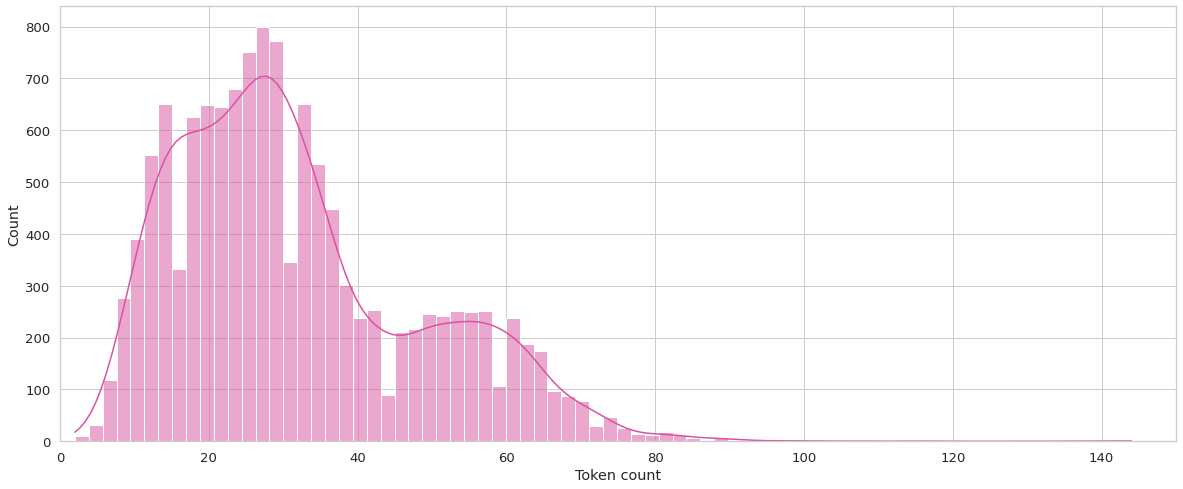

In [ ]:
sequence_lengths = count_sequence_length(train_hate, val_hate, test_hate)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

144

In [ ]:
# number of tweets with more than 100 tokens
sl = [x for x in sequence_lengths if x > 100]
len(sl)

5

From the histogram above, we can see that most of the tokenized tweets have less then 100 tokens. However, the longest tokenized tweet has 144 tokens.

**Tweet Preprocessing**

In [ ]:
train_hate_prep = train_hate.map(preprocessing_function)
val_hate_prep = val_hate.map(preprocessing_function)
test_hate_prep = test_hate.map(preprocessing_function)

In [ ]:
show_data_examples(train_hate_prep, 175, 200, Fore.LIGHTRED_EX)

EXAMPLES:

 176. THIS WOMEN CAN DO ONLY ONE THINK, BACK INTO HER RAT emoji rat emoji  HOLE NEVER TO COME OUT AGAIN emoji rat emoji IF SHE SHOW UP ON SURFACE AM CALL ->  hate
 177. actnow! usa eb5 eb5 visa immigrant foreign investor visa Program Laws ARE Changing! $500k investment. Payment plans available. Use bitcoin ether cryptocurrency. Become a US Citizen! Visit us at Contact us TODAY at gbibuildingco@HTTPURL. RT ->  non-hate
 178. The Latest: Spanish PM lets migrant boat dock at Valencia   You idiots are killing Spain with islamists... ->  hate
 179. Afghan and Pakistani migrants were shot at as they tried to invade Hungary - Free Speech Time - @USER ->  non-hate
 180. @USER shut the fuck up hes not gonna dick you was gonna send u this dope steroline edit but u can go cry to olly ->  hate
 181. you low life scum, pathetic, deprave, pile of shit, maggots. like i said that brainless skank bitch should've died ->  hate
 182. @USER @USER bitch we r now TxF sluts ->  non-hate
 183. @USE

The preprocessing function has performed the actions described above in the preprocessing section of the *emotion* dataset.



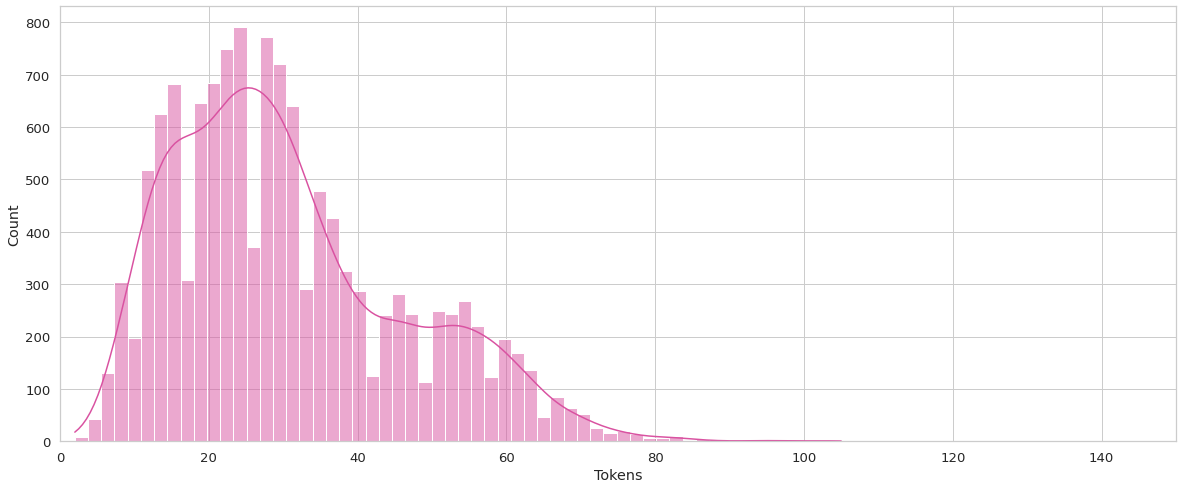

In [ ]:
sequence_lengths = count_sequence_length(train_hate_prep, val_hate_prep, test_hate_prep)
plot_sequence_length(sequence_lengths)

In [ ]:
max(sequence_lengths)

105

In [ ]:
# number of tweets with more than 100 tokens
sl = [x for x in sequence_lengths if x > 100]
len(sl)

3

From the histogram above, we can see that most of the tokenized preprocessed tweets have less then 100 tokens. However, the longest tokenized tweet has 105 tokens.

### 4.3 - Data Tokenization

In this section, tweets are tokenized by using the BERTweet tokenizer. We will first apply the tokenization to the original tweets. Then, we will tokenize the preprocessed tweets.

To tokenize the tweets, we will use the `max_length` padding option, which truncates the tokenized tweets to the same length. Most of the original tweets have a length below 80, however, the longest tokenized tweets have 144 tokens.

Therefore, we can use a max length of 100 so that most of the tweets in the dataset won't be truncated.


In [ ]:
MAX_LEN = 100

In [ ]:
# helper functions

def tokenize_function(examples):
  """ Call the tokenizer on a tweet. """

  return tokenizer(examples["text"], padding='max_length', truncation=True, max_length=MAX_LEN)


def tokenize_datasets(train, val, test):
  """ Tokenize the tweets in the training, validation and test sets. After that,
  the 'label' column is renamed to 'labels' and the 'text' column is removed. 
  Finally, the dataset's format is set to 'torch'. The resulting datasets have the
  columns required by the BERTweet tokenizer."""

  train_tokenized_dataset = train.map(tokenize_function, batched=True)
  train_tokenized_dataset = train_tokenized_dataset.rename_column('label', 'labels')
  train_tokenized_dataset = train_tokenized_dataset.remove_columns(['text'])
  train_tokenized_dataset = train_tokenized_dataset.with_format('torch')

  val_tokenized_dataset = val.map(tokenize_function, batched=True)
  val_tokenized_dataset = val_tokenized_dataset.rename_column('label', 'labels')
  val_tokenized_dataset = val_tokenized_dataset.remove_columns(['text'])
  val_tokenized_dataset = val_tokenized_dataset.with_format('torch')

  test_tokenized_dataset = test.map(tokenize_function, batched=True)
  test_tokenized_dataset = test_tokenized_dataset.rename_column('label', 'labels')
  test_tokenized_dataset = test_tokenized_dataset.remove_columns(['text'])
  test_tokenized_dataset = test_tokenized_dataset.with_format('torch')

  return train_tokenized_dataset, val_tokenized_dataset, test_tokenized_dataset


**Original Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_hate, val_tokenized_hate, test_tokenized_hate = tokenize_datasets(train_hate, val_hate, test_hate)

**Preprocessed Tweet Tokenization**

In [ ]:
# Data tokenization
train_tokenized_hate_prep, val_tokenized_hate_prep, test_tokenized_hate_prep = tokenize_datasets(train_hate_prep, val_hate_prep, test_hate_prep)

### 4.4 - Model finetuning

This section contains the code used to finetuned $BERTeet_{base}$ on both the original and the preprocessed tweets of the *hate* dataset.

For each kind of data, we select the model with the best validation accuracy. The table below shows a summary of the hyperparameters of the best models.

Dataset                 | Batch Size | Number of Epochs | Validation Accuracy
----------------------  |------------| ----| -------
hate (original)         | 32         | 2   | 80.3%
hate (preprocessed)     | 16         | 2   | 78.1%

As we can see, the models reached the best validation accuracy in 2 epochs, using a batch size of 16 or 32.

In [ ]:
accuracy = load_metric("accuracy")

In [ ]:
# Hyperparameters
batch_sizes = [16, 32]
epochs = [2, 3, 4]

In [ ]:
def compute_accuracy(eval_pred):
  """ Compute accuracy on the model's predictions. """
  
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
num_classes = train_hate.features['label'].num_classes
bertweet_hate = AutoModelForSequenceClassification.from_pretrained(BERTWEET_BASE, num_labels=num_classes)

Downloading:   0%|          | 0.00/517M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/bertweet-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: 

**Original data**

In [ ]:
best_model_hate = None
best_accuracy_hate = 0
best_epoch_hate = 0
best_batch_size_hate = 0

models_hate = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_hate_'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)

    trainer = Trainer(
        model=bertweet_hate,
        args=args,
        train_dataset=train_tokenized_hate,
        eval_dataset=val_tokenized_hate,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_hate)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_hate.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_hate:
      best_accuracy_hate = val_accuracy
      best_model_hate = trainer
      best_epoch_hate = epoch
      best_batch_size_hate = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1126


Epoch,Training Loss,Validation Loss,Accuracy
1,0.684600,0.690615,0.573000
2,0.674100,0.660920,0.661000


Saving model checkpoint to trainer_hate_16_2/checkpoint-500
Configuration saved in trainer_hate_16_2/checkpoint-500/config.json
Model weights saved in trainer_hate_16_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_2/checkpoint-1000
Configuration saved in trainer_hate_16_2/checkpoint-1000/config.json
Model weights saved in trainer_hate_16_2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 564


 
Validation accuracy (batch size 16 and epochs 2): 0.661
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.478203,0.774000
2,0.400600,0.454387,0.803000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_32_2/checkpoint-500
Configuration saved in trainer_hate_32_2/checkpoint-500/config.json
Model weights saved in trainer_hate_32_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1689


 
Validation accuracy (batch size 32 and epochs 2): 0.803
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.332800,0.544180,0.766000
2,0.226900,0.718171,0.794000
3,0.132200,0.869335,0.789000


Saving model checkpoint to trainer_hate_16_3/checkpoint-500
Configuration saved in trainer_hate_16_3/checkpoint-500/config.json
Model weights saved in trainer_hate_16_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_3/checkpoint-1000
Configuration saved in trainer_hate_16_3/checkpoint-1000/config.json
Model weights saved in trainer_hate_16_3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_3/checkpoint-1500
Configuration saved in trainer_hate_16_3/checkpoint-1500/config.json
Model weights saved in trainer_hate_16_3/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 846


 
Validation accuracy (batch size 16 and epochs 3): 0.789
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.793692,0.776000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.793692,0.776000
2,0.099600,1.005491,0.769000
3,0.099600,1.114714,0.790000


Saving model checkpoint to trainer_hate_32_3/checkpoint-500
Configuration saved in trainer_hate_32_3/checkpoint-500/config.json
Model weights saved in trainer_hate_32_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2252


 
Validation accuracy (batch size 32 and epochs 3): 0.79
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.092400,0.905089,0.786000
2,0.074500,1.206654,0.776000
3,0.045100,1.237608,0.787000
4,0.028100,1.341593,0.793000


Saving model checkpoint to trainer_hate_16_4/checkpoint-500
Configuration saved in trainer_hate_16_4/checkpoint-500/config.json
Model weights saved in trainer_hate_16_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_4/checkpoint-1000
Configuration saved in trainer_hate_16_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_16_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_4/checkpoint-1500
Configuration saved in trainer_hate_16_4/checkpoint-1500/config.json
Model weights saved in trainer_hate_16_4/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_16_4/checkpoint-2000
Configuration saved in trainer_hate_16_4/checkpoint-2000/config.json
Model weights saved in trainer_hate_16_4/checkpo

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1128


 
Validation accuracy (batch size 16 and epochs 4): 0.793
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.206334,0.776000
2,0.039400,1.251963,0.788000
3,0.039400,1.458718,0.780000
4,0.020000,1.435398,0.779000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_32_4/checkpoint-500
Configuration saved in trainer_hate_32_4/checkpoint-500/config.json
Model weights saved in trainer_hate_32_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_32_4/checkpoint-1000
Configuration saved in trainer_hate_32_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_32_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


 
Validation accuracy (batch size 32 and epochs 4): 0.779
 


In [ ]:
print('** Best model for Hate Speech Detection **')
print(f'batch size: {best_batch_size_hate}, epochs: {best_epoch_hate}, validation accuracy: {best_accuracy_hate}')
# 16-4, 32-4

** Best model for Hate Speech Detection **
batch size: 32, epochs: 2, validation accuracy: 0.803


**Preprocessed data**

In [ ]:
best_model_hate_prep = None
best_accuracy_hate_prep = 0
best_epoch_haten_prep = 0
best_batch_size_hate_prep = 0

models_hate_prep = []

for epoch in epochs:
  for batch_size in batch_sizes:

    args = TrainingArguments(output_dir='trainer_hate_prep'+str(batch_size)+'_'+str(epoch),
                              evaluation_strategy="epoch",
                              num_train_epochs=epoch,
                              per_device_train_batch_size=batch_size)
    
    trainer = Trainer(
        model=bertweet_hate,
        args=args,
        train_dataset=train_tokenized_hate_prep,
        eval_dataset=val_tokenized_hate_prep,
        compute_metrics=compute_accuracy,
    )

    trainer.train()
  
    predictions = trainer.predict(val_tokenized_hate_prep)
    preds = np.argmax(predictions.predictions, axis=-1)
    val_accuracy = accuracy.compute(predictions=preds, references=predictions.label_ids)['accuracy']

    print(f'{Fore.MAGENTA} \nValidation accuracy (batch size {batch_size} and epochs {epoch}): {val_accuracy}\n {Fore.BLACK}')
    
    models_hate_prep.append(dict(val_accuracy=val_accuracy,
                       batch_size=batch_size,
                       epochs=epoch
                       ))

    if val_accuracy > best_accuracy_hate_prep:
      best_accuracy_hate_prep = val_accuracy
      best_model_hate_prep = trainer
      best_epoch_hate_prep = epoch
      best_batch_size_hate_prep = batch_size


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1126


Epoch,Training Loss,Validation Loss,Accuracy
1,0.083800,1.144966,0.784000
2,0.043100,1.390039,0.781000


Saving model checkpoint to trainer_hate_prep16_2/checkpoint-500
Configuration saved in trainer_hate_prep16_2/checkpoint-500/config.json
Model weights saved in trainer_hate_prep16_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_2/checkpoint-1000
Configuration saved in trainer_hate_prep16_2/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep16_2/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 2
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 564


 
Validation accuracy (batch size 16 and epochs 2): 0.781
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.238325,0.773000
2,0.031200,1.477002,0.778000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_2/checkpoint-500
Configuration saved in trainer_hate_prep32_2/checkpoint-500/config.json
Model weights saved in trainer_hate_prep32_2/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 1689


 
Validation accuracy (batch size 32 and epochs 2): 0.778
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.062700,1.618517,0.764000
2,0.025700,1.531692,0.785000
3,0.010400,1.666404,0.779000


Saving model checkpoint to trainer_hate_prep16_3/checkpoint-500
Configuration saved in trainer_hate_prep16_3/checkpoint-500/config.json
Model weights saved in trainer_hate_prep16_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_3/checkpoint-1000
Configuration saved in trainer_hate_prep16_3/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep16_3/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_3/checkpoint-1500
Configuration saved in trainer_hate_prep16_3/checkpoint-1500/config.json
Model weights saved in trainer_hate_prep16_3/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  B

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 3
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 846


 
Validation accuracy (batch size 16 and epochs 3): 0.779
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.724600,0.762000
2,0.017600,1.743068,0.763000
3,0.017600,1.768635,0.769000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_3/checkpoint-500
Configuration saved in trainer_hate_prep32_3/checkpoint-500/config.json
Model weights saved in trainer_hate_prep32_3/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2252


 
Validation accuracy (batch size 32 and epochs 3): 0.769
 


Epoch,Training Loss,Validation Loss,Accuracy
1,0.041000,1.744837,0.759000
2,0.028900,1.557923,0.753000
3,0.015900,1.713759,0.773000
4,0.010600,1.927164,0.767000


Saving model checkpoint to trainer_hate_prep16_4/checkpoint-500
Configuration saved in trainer_hate_prep16_4/checkpoint-500/config.json
Model weights saved in trainer_hate_prep16_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_4/checkpoint-1000
Configuration saved in trainer_hate_prep16_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep16_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_4/checkpoint-1500
Configuration saved in trainer_hate_prep16_4/checkpoint-1500/config.json
Model weights saved in trainer_hate_prep16_4/checkpoint-1500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep16_4/checkpoint-2000
Configuration saved in trainer_hate_prep16_4/checkpoint-2000/config.json
Mode

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 9000
  Num Epochs = 4
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 1128


 
Validation accuracy (batch size 16 and epochs 4): 0.767
 


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,1.834215,0.762000
2,0.022300,2.130250,0.760000
3,0.022300,1.965113,0.763000
4,0.005500,2.040073,0.759000


***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_4/checkpoint-500
Configuration saved in trainer_hate_prep32_4/checkpoint-500/config.json
Model weights saved in trainer_hate_prep32_4/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8
Saving model checkpoint to trainer_hate_prep32_4/checkpoint-1000
Configuration saved in trainer_hate_prep32_4/checkpoint-1000/config.json
Model weights saved in trainer_hate_prep32_4/checkpoint-1000/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 8


Training completed. Do not forget to share your model on huggingface.co/models =)


***** Running Prediction *****
  Num examples = 1000
  Batch size = 8


 
Validation accuracy (batch size 32 and epochs 4): 0.759
 


In [ ]:
print('** Best model for Hate Speech Detection with preprocessed tweets **')
print(f'batch size: {best_batch_size_hate_prep}, epochs: {best_epoch_hate_prep}, validation accuracy: {best_accuracy_hate_prep}')


** Best model for Hate Speech Detection with preprocessed tweets **
batch size: 16, epochs: 2, validation accuracy: 0.781


### 4.5 - Models evaluation

In order to evaluate the models' performances, we will compute the following metrics on the test sets:
- Accuracy
- Macro-averaged precision
- Macro-averaged recall
- Macro-averaged $F_{1}$  score

The results are shown in the table below, together with the $F_{1}$  scores obtained by **RoB-RT**, one of the models reported as a benchmark by TweetEval. We will compare the models' performances with RoB-RT because this is the benchmark model that obtained overall the highest results. 

Dataset                 | Accuracy | Precision | Recall | $F_{1}$  score | TweetEval benchmark ($F_{1}$  score)
----------------------  |-------| ------|-------|------| ---
hate (original)         | 57.0 | 70.6 | 62.3 | 54.2 | 52.3±0.2
hate (preprocessed)     | 56.0 | 67.7 | 61.1 | 53.5

Conversely to what we could have expected, the model finetuned on the original tweets and the model finetuned on the preprocessed tweets obtained more or less the same results in terms of performances. This might be due to the fact that, the way emoji and hashtags get encoded does not depend much on how they are represented in the input tweets, but rather on the context in which they appear.

To conclude, we can see that, overall, the $F_{1}$  scores obtained by finetuning BERTweet are in the same range of the $F_{1}$ scores reported in the TweetEval benchmark.

In [ ]:
f1_score = load_metric('f1')
precision = load_metric('precision')
recall = load_metric('recall')

**Original data**

In [ ]:
predictions_hate = best_model_hate.predict(test_tokenized_hate)
preds_hate = np.argmax(predictions_hate.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


In [ ]:
accuracy_hate = accuracy.compute(predictions=preds_hate, references=predictions_hate.label_ids)
precision_hate = precision.compute(predictions=preds_hate, references=predictions_hate.label_ids, average='macro')
recall_hate = recall.compute(predictions=preds_hate, references=predictions_hate.label_ids, average='macro')
f1_score_hate = f1_score.compute(predictions=preds_hate, references=predictions_hate.label_ids, average='macro')

In [ ]:
print('** Hate Speech Detection **')
print('Test accuracy:', accuracy_hate['accuracy'])
print('Precision (macro average):', precision_hate['precision'])
print('Recall (macro average):', recall_hate['recall'])
print('F1 score (macro average):', f1_score_hate['f1'])

** Hate Speech Detection **
Test accuracy: 0.5696969696969697
Precision (macro average): 0.7056715806715806
Recall (macro average): 0.6232895818378603
F1 score (macro average): 0.5425109959063361


**Preprocessed data**

In [ ]:
predictions_hate_prep = best_model_hate_prep.predict(test_tokenized_hate_prep)
preds_hate_prep = np.argmax(predictions_hate_prep.predictions, axis=-1)

***** Running Prediction *****
  Num examples = 2970
  Batch size = 8


In [ ]:
accuracy_hate_prep = accuracy.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids)
precision_hate_prep = precision.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids, average='macro')
recall_hate_prep = recall.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids, average='macro')
f1_score_hate_prep = f1_score.compute(predictions=preds_hate_prep, references=predictions_hate_prep.label_ids, average='macro')

In [ ]:
print('** Hate Speech Detection with preprocessed tweets **')
print('Test accuracy:', accuracy_hate_prep['accuracy'])
print('Precision (macro average):', precision_hate_prep['precision'])
print('Recall (macro average):', recall_hate_prep['recall'])
print('F1 score (macro average):', f1_score_hate_prep['f1'])

** Hate Speech Detection with preprocessed tweets **
Test accuracy: 0.55993265993266
Precision (macro average): 0.6774473176568261
Recall (macro average): 0.6114914623215195
F1 score (macro average): 0.5347482848458168


### 5 - Conclusions

In this notebook we finetuned BERTweet on the Hate Speech Detection task.

We have seen that there are no big differences in finetuning BERTweet with or without applying a further tweet preprocessing step to replace emojies and hashtags with text. This can be explained by the fact that BERT is a contextual encoder that considers both right and left contexts when generating the input embedding. Therefore, the way emojis and hashtags are encoded in the input tweets doesn't seem to have an impact on the tweet embedding and, consequently, on the task performances.

Furthermore, it is interesting to notice that finetuning BERTweet with just 2 or 3 training epochs allows us to reach the same performaces reported in the TweetEval benchmark.

To conclude, it's important to highlight that we can use the same procedure presented in this notebook to finetune BERTweet on different datasets, in order to perform other NLP tasks, such as Sentiment Analysis and Emotion Recognition.